In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import norm
import lmfit
from tqdm import tqdm
import xarray as xr
from glotaran.optimization.optimize import optimize
from glotaran.io import load_model
from glotaran.io import load_parameters
from glotaran.io import save_dataset
from glotaran.io.prepare_dataset import prepare_time_trace_dataset
from glotaran.project.scheme import Scheme
# load all and average the matrix
def mat_avg(name, file_num):
    first_array = np.loadtxt(name+str(1))-np.loadtxt(name+str(1))
    rows = len(first_array)
    columns = len(first_array[0])
    mat_array = np.zeros((rows, columns, file_num))
    for i in range(file_num):
        mat_array[:, :, i] = np.loadtxt(name+str(i+1))
        # print(data_file)
    sum_array = np.sum(mat_array, axis=2)
    avg_array = sum_array / file_num
    np.savetxt(name+"averaged", avg_array, fmt="%f", delimiter="\t")
    return avg_array, mat_array

# load TaTime0
def load_tatime(file_name):
    #time_total = np.loadtxt(file_name)[:, 0]
    #tatime = time_total[time_total != 0]
    tatime = np.loadtxt(file_name)[:,0]
    idx = np.loadtxt(file_name).shape[1]-2
    tatime = tatime[:idx]
    return tatime

# load tawavelength
def load_tawavelength(file_name):
    tawavelength = np.loadtxt(file_name)[:, 1]
    return tawavelength

class load_single:
    def __init__(self, file_name):
        data = np.loadtxt(file_name)
        self.tawavelength = data[:, 0]
        self.spec_ta = data[:, 1]
        self.spec_on = data[:, 2]
        self.spec_off = data[:, 3]
    
    def plot(self):
        fig, ax = plt.subplots(nrows = 2)
        ax[1].plot(self.tawavelength, self.spec_ta, label='TA')
        ax[0].plot(self.tawavelength, self.spec_on, label='ON')
        ax[0].plot(self.tawavelength, self.spec_off, label='OFF')
        ax[0].legend()
        ax[1].set_xlabel('Wavelength (nm)')
        ax[0].set_ylabel('ΔOD')
        ax[1].set_ylabel('ΔOD')
        ax[1].set_title('TA spectrum')
        ax[0].set_title('On and Off spectrum')
        plt.show()

# auto load all parallel expts into the object load_spectra
class load_spectra:
    def __init__(self, file_inp, num_spec=None):
        self.file_inp = file_inp
        if num_spec is None or num_spec == 1:
            self.num_spec = 1
            self.tamatrix_avg = np.loadtxt(self.file_inp)
            self.tatime = load_tatime(self.file_inp)
            self.tawavelength = load_tawavelength(self.file_inp)
        else:
            self.num_spec = num_spec
            # load tatime and tawavelength axes
            self.tatime = load_tatime(self.file_inp+'1')
            self.tawavelength = load_tawavelength(self.file_inp+'1')
            # average the matrix
            self.tamatrix_avg, self.mat_array = mat_avg(self.file_inp, num_spec)
        
    def mat_sub(self, obj_bg, modifier=None):
        if modifier is None:
            modifier = 1
        self.tamatrix_avg = self.tamatrix_avg - obj_bg.tamatrix_avg * modifier
        self.mat_array = self.mat_array - obj_bg.tamatrix_avg[:, :, np.newaxis] * modifier
        
    # plot 1ps spectrum
    def get_1ps(self):
        diff = np.abs(self.tatime - 1)
        pt = pt = np.argmin(diff)
        self.spec_1ps = self.tamatrix_avg[:, pt+2]
        self.fig_s, self.ax_s = plt.subplots()
        self.ax_s.plot(self.tawavelength, self.spec_1ps)
        self.ax_s.set_title(self.file_inp)
        self.ax_s.set_xlabel('Wavelength (nm)')
        self.ax_s.set_ylabel('ΔOD')
        return self.spec_1ps

    # plot multiple parallel traces to see photodamage
    def get_traces(self, wavelength,disable_plot = None):
        self.fig_k, self.ax_k = plt.subplots()
        self.trace_array = np.zeros((len(self.tatime), self.num_spec))
        diff = np.abs(self.tawavelength - wavelength)
        pt = np.argmin(diff)
        if self.num_spec == 1:
            self.trace_avg = self.tamatrix_avg[pt,2:]
            self.ax_k.plot(np.log(self.tatime), self.trace_avg,
                            label=f'{wavelength} nm trace')
        else:           
            for i in range(self.num_spec):
                self.trace_array[:, i] = self.mat_array[pt, 2:, i]
                self.ax_k.plot(
                        np.log(self.tatime), self.trace_array[:, i], label=f'{wavelength} nm trace {i+1}')

            self.trace_avg = self.tamatrix_avg[pt, 2:]
            self.ax_k.plot(np.log(self.tatime), self.trace_avg,
                            label=f'{wavelength} nm trace averaged')
        self.ax_k.legend()
        self.ax_k.set_xlabel('Time (Log scale ps)')
        self.ax_k.set_ylabel('ΔOD')
        self.ax_k.set_title(self.file_inp)

        return self.trace_avg
    
#compare traces from load_spectra object
class compare_traces:
    def __init__(self, obj, wavelength):
        self.wavelength = wavelength
        self.tatime = obj.tatime
        trace = obj.get_traces(wavelength, disable_plot = True).reshape(1, -1)
        self.trace_array = np.empty((0,len(self.tatime)))
        print(self.trace_array.size)
        print(trace.size)
        self.trace_array = np.append(self.trace_array, trace, axis = 0)
        self.wavelength_list = [self.wavelength]  
        self.name_list =  [obj.file_inp]      
    def add_trace(self,obj,wavelength = None):
        self.name_list.append(obj.file_inp)
        if wavelength is None:
            trace_toadd = obj.get_traces(self.wavelength, disable_plot = True).reshape(1, -1)
            self.wavelength_list.append(self.wavelength)
        else:
            try:
                trace_toadd = obj.get_traces(wavelength, disable_plot = True).reshape(1, -1)
                self.wavelength_list.append(wavelength)
            except:
                print('Invalid wavelength')
                return
        self.trace_array = np.append(self.trace_array,trace_toadd, axis = 0)
    
    def plot(self):
        self.fig, self.ax = plt.subplots()
        for i in range(len(self.trace_array)):
            self.ax.plot(np.log(self.tatime),self.trace_array[i,:]/np.max(np.abs(self.trace_array[i,:])), label = f'{self.name_list[i]} @ {self.wavelength_list[i]} nm')
        self.ax.legend()
        self.ax.set_title('Normalized traces with logarithmic time axis')
        self.ax.set_xlabel('Time (Log scale ps)')
        self.ax.set_ylabel('ΔOD')
            
class glotaran:
    def __init__(self,matrix_corr,tatime,tawavelength):
        self.filename = matrix_corr
        self.tatime = np.loadtxt(tatime)
        self.tawavelength = np.loadtxt(tawavelength)
        self.output_matrix = np.loadtxt(matrix_corr)
        self.output_matrix = np.append(self.tatime.reshape(1,-1),self.output_matrix, axis = 0)
        self.output_matrix = np.append(np.append("",self.tawavelength).reshape(1,-1).T,self.output_matrix, axis = 1)
        self.header = self.filename+'\n\nTime explicit\nintervalnr '+ str(len(self.tatime))
        np.savetxt(self.filename+"glo.ascii",self.output_matrix,header = self.header,fmt='%s',comments='',delimiter = '\t')
        
class load_glotaran:
    def __init__(self,dir):
        self.filename = dir
        matrix = np.loadtxt(dir,skiprows = 4, delimiter = '\t',dtype=str)
        matrix[matrix==''] = np.nan
        matrix = matrix.astype(np.float64)
        self.tatime = matrix[0,1:]
        self.tawavelength = matrix[1:,0]
        self.tamatrix = matrix[1:,1:]
        
class tamatrix_importer:
    def __init__(self,filename=None, startnm = None, endnm = None, load_spectra = None, load_glotaran=None, tamatrix = None, tatime = None, tawavelength = None,name = None):
        if startnm is None:
            self.startnm = 0
        else:
            self.startnm = startnm
        if endnm is None:
            self.endnm = 1200
        else:
            self.endnm = endnm
        #load from file if no object is given
        if filename is not None:   
            # Load firstcol wave and find startrow and endrow
            # filename = input("Enter the filename for firstcol wave: ")
            self.filename = filename
            firstcol = np.loadtxt(self.filename)[:, 1]
            if self.startnm < np.min(firstcol):
                self.startrow = np.argmin(firstcol)
            else:
                for index in range(len(firstcol)):
                    if firstcol[index] > self.startnm:
                        self.startrow = index
                        break
            if self.endnm > np.max(firstcol):
                self.endrow = np.argmax(firstcol)
            else:
                for index in range(len(firstcol)):
                    if firstcol[index] > self.endnm:
                        self.endrow = index
                        break

            # Load TAwavelength waves
            self.tawavelength = np.loadtxt(self.filename, skiprows=self.startrow, max_rows=self.endrow-self.startrow)[:,1]
            #np.savetxt(self.filename+"_tawavelength",tawavelength,fmt='%1.5f')

            # Trim TAtime wave
            self.tatime = np.loadtxt(self.filename)[:,0]
            idx = np.loadtxt(self.filename).shape[1]-2
            self.tatime = self.tatime[:idx]
            #np.savetxt(self.filename+"_tatime",tatime,fmt='%1.5f')

            # Load TAmatrix waves
            self.tamatrix = np.loadtxt(self.filename, skiprows=self.startrow, max_rows=self.endrow-self.startrow, usecols=np.arange(2, idx+2))
            #np.savetxt(self.filename+"_tamatrix",self.tamatrix,fmt='%1.5f'
            
        elif load_spectra is not None:
            self.tawavelength = load_spectra.tawavelength
            self.tatime = load_spectra.tatime
            self.tamatrix = load_spectra.tamatrix_avg[:,2:]
            self.filename = load_spectra.file_inp
        
        elif load_glotaran is not None:
            self.tawavelength = load_glotaran.tawavelength
            self.tatime = load_glotaran.tatime
            self.tcorr = load_glotaran.tamatrix
            self.filename = load_glotaran.filename
        """ else:
            self.tawavelength = np.loadtxt(tawavelength)
            self.tatime = np.loadtxt(tatime)
            self.tcorr = np.loadtxt(tamatrix)
            self.filename = tamatrix """
            
        if name is not None:
            self.filename = name
        
        self.fit_results = {}

    def contour(self,time_min,time_max):
        # Create a contour plot
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        plt.contourf(X,Y,self.tamatrix,[-0.005,-0.001,-0.0005,0,0.0005,0.001,0.005],cmap='rainbow')
        plt.ylim(time_min,time_max)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.colorbar()
        plt.show()

    def save_all(self,filename,mat):
        if mat == 'original':
            matrix = self.tamatrix.copy()
            print("Original matrix is selected\n")
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
            print("Background corrected matrix is selected\n")
        else:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')
        print(filename+"_tawavelength has been saved\n")
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')
        print(filename+"_tatime has been saved\n")
        np.savetxt(filename+"_tamatrix",matrix,fmt='%1.5f')
        print(filename+"_tatime has been saved\n")
        

    def save_tamatrix(self,filename, mat=None):
        if mat is None:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        if mat == 'original':
            matrix = self.tamatrix.copy()
            print("Original matrix is selected\n")
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
            print("Background corrected matrix is selected\n")
        else:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        if filename == self.filename:
            print("Cannot overwrite original matrix, choose another name\n")
        else:
            np.savetxt(filename+"_tamatrix",matrix,fmt='%1.5f')
    
    def save_tatime(self,filename):
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')

    def save_tawavelength(self,filename):
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')
        
    def save_axes(self, filename):
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')

    def auto_bgcorr(self, points):
        npavg = 0
        self.bgcorr = self.tamatrix.copy()
        for i in range(points):
            npavg += self.tamatrix[:, i]

        print("The number of time points taken as background: "+str(i+1))
        npavg /= points
        #np.savetxt(self.filename+"_tamatrix_npavg", npavg, fmt='%1.5f')
        for x in range(self.tamatrix.shape[1]):
            self.bgcorr[:, x] = self.tamatrix[:, x] - npavg
        #np.savetxt(self.tamatrix+"_tamatrix_bgcorr", self.bgcorr, fmt='%1.5f')

        # Create a figure and axis for the contour plot
        # Create contour plot
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        plt.contourf(X, Y, self.bgcorr, [-0.005, -0.001, -0.0005,
                 0, 0.0005, 0.001, 0.005], cmap='rainbow')
        plt.ylim(-1, 1)
        plt.colorbar()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.show()

        return self.bgcorr
    # zero time correction

    def auto_tcorr(self, line_file):
        '''
        This macro corrects a TA matrix (time versus wavelength or wavenumber) for the measured chirp in the continuum.
        To use it first plot the TA matrix as a contour plot and zoom in on the region around zerotime, say -1 ps to +1 ps.
        Then use the "correction_line.py" tool to draw in a contour that follows the curvature of the onset of the signal.
        Typically this curve would be lower, at more negative times, in the blue part of the spectrum and then extending up
        to more positive time delays in the red part of the spectrum.
        To get the "Draw Wave Monotonic" tool, first <Show Tools>, then right click + option button on the polygon tool. Select
        "Draw wave Monotonic" and then click along to place data points on the contour plot, double clicking when you reach the last one.
        This will make two waves, named something like W_Ypoly0 (the y points) and W_XPoly0 (the x points).
        "matrix" is the name of the TA matrix you are correcting, e.g. "TAmatrix0".
        "TAtime" is the name if the time axis, e.g. "TAtime0"
        "TAwavelength" is the name of the wavelength axis, e.g. "tawavelength"
        "zerotime_x" is the wave with the x values of the zerotime wave drawn above, e.g. "W_XPoly0"
        "zerotime_y" is the wave with the y values of the zerotime wave drawn above, e.g. "W_YPoly0"
        Note that you could also fit the kinetics at a lot of different wavelengths and thereby determine a series of zerotimes ("zerotime_y")
        at a series of wavelengths ("zerotime_x")
        So you'd call this macro with a command line like: Correct_zerotime("TAmatrix0","TAtime0", "tawavelength","W_XPoly0","W_YPoly0")
        '''

        # import correction line from drawing script
        zerotime_x = np.loadtxt(line_file)[:, 0]
        zerotime_y = np.loadtxt(line_file)[:, 1]
        # generate contempory file and output matrix
        time_temp = self.tatime.copy()
        try:
            oldmatrix = self.bgcorr.copy()
        except:
            print('bgcorr matrix not found. zero time correction on original matrix')
            oldmatrix = self.tamatrix.copy()
        self.tcorr = np.zeros_like(self.tamatrix)

        for i in range(len(self.tawavelength)):
            # Tatime axis minus time offset from the drawn line
            time_temp = self.tatime + np.interp(self.tawavelength[i], zerotime_x, zerotime_y)
            # extrapolate TAsignal to match corrected time axis
            self.tcorr[i, :] = np.interp(time_temp, self.tatime, oldmatrix[i, :])
            # Add the following smoothing line to clean up the spectra, with a slight loss in time resolution.
            # newmatrix[i, :] = np.convolve(kin_temp2[i, :], np.ones(3)/3, mode='same')
        #save tcorred matrix
        #np.savetxt(newmatrixname, newmatrix, fmt='%1.5f')
        
        # Create contour plot with plot_contour()
        # Create contour plot
        fig, ax = plt.subplots()
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        contour = ax.contour(
            X, Y, self.tcorr, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01])
        plt.ylim(-1, 1)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.draw()
    
        return self.tcorr
    
    def auto_tcorr_fit(self):
        '''
        This macro corrects a TA matrix (time versus wavelength or wavenumber) for the measured chirp in the continuum.
        To use it first plot the TA matrix as a contour plot and zoom in on the region around zerotime, say -1 ps to +1 ps.
        Then use the "correction_line.py" tool to draw in a contour that follows the curvature of the onset of the signal.
        Typically this curve would be lower, at more negative times, in the blue part of the spectrum and then extending up
        to more positive time delays in the red part of the spectrum.
        To get the "Draw Wave Monotonic" tool, first <Show Tools>, then right click + option button on the polygon tool. Select
        "Draw wave Monotonic" and then click along to place data points on the contour plot, double clicking when you reach the last one.
        This will make two waves, named something like W_Ypoly0 (the y points) and W_XPoly0 (the x points).
        "matrix" is the name of the TA matrix you are correcting, e.g. "TAmatrix0".
        "TAtime" is the name if the time axis, e.g. "TAtime0"
        "TAwavelength" is the name of the wavelength axis, e.g. "tawavelength"
        "zerotime_x" is the wave with the x values of the zerotime wave drawn above, e.g. "W_XPoly0"
        "zerotime_y" is the wave with the y values of the zerotime wave drawn above, e.g. "W_YPoly0"
        Note that you could also fit the kinetics at a lot of different wavelengths and thereby determine a series of zerotimes ("zerotime_y")
        at a series of wavelengths ("zerotime_x")
        So you'd call this macro with a command line like: Correct_zerotime("TAmatrix0","TAtime0", "tawavelength","W_XPoly0","W_YPoly0")
        '''

        # import correction line from drawing script
        zerotime_x = self.t0_list[0]
        zerotime_y = self.t0_list[2]
        # generate contempory file and output matrix
        time_temp = self.tatime.copy()
        try:
            oldmatrix = self.bgcorr.copy()
        except:
            print('bgcorr matrix not found. zero time correction on original matrix')
            oldmatrix = self.tamatrix.copy()
        self.tcorr = np.zeros_like(self.tamatrix)

        for i in range(len(self.tawavelength)):
            # Tatime axis minus time offset from the drawn line
            time_temp = self.tatime + np.interp(self.tawavelength[i], zerotime_x, zerotime_y)
            # extrapolate TAsignal to match corrected time axis
            self.tcorr[i, :] = np.interp(time_temp, self.tatime, oldmatrix[i, :])
            # Add the following smoothing line to clean up the spectra, with a slight loss in time resolution.
            # newmatrix[i, :] = np.convolve(kin_temp2[i, :], np.ones(3)/3, mode='same')
        #save tcorred matrix
        #np.savetxt(newmatrixname, newmatrix, fmt='%1.5f')
        
        # Create contour plot with plot_contour()
        # Create contour plot
        fig, ax = plt.subplots()
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        contour = ax.contour(
            X, Y, self.tcorr, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01])
        plt.ylim(-1, 1)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.draw()
    
        return self.tcorr
    
    def glotaran(self):
        output_matrix = glotaran(self.tcorr,self.tatime,self.tawavelength)
        #return output_matrix #Don't need this array in python. Use Glotaran legacy 
    
    def pyglotaran(self,mat=None):
        '''
        export tcorr matrix to pyglotaran xarray dataset
        e.g.
        dataset = tamatrix.pyglotaran()
        '''
        time_vals = self.tatime
        spectral_vals = self.tawavelength
        data_vals = self.mat_selector(mat).T

        # Define dimensions and coordinates
        dims = ('time', 'spectral')
        coords = {'time': time_vals, 'spectral': spectral_vals}

        # Create xarray dataset
        dataset = xr.Dataset(
            {'data': (dims, data_vals)},
            coords=coords,
            attrs={'source_path': 'dataset_1.nc'}
        )
        print(dataset)
        return dataset
    
    def mat_selector(self,mat=None):
        if mat is None:
            try:   
                matrix = self.tcorr.copy()
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Original matrix used')
        elif mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        elif mat == 'tcorr':
            matrix = self.tcorr.copy()
        else:
            try:   
                matrix = self.tcorr.copy()
                print('Invalid mat value. Use tcorrrected matrix')
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Invalid mat value. Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Invalid mat value. Original matrix used')
        return matrix
            
    def auto_taspectra(self,time_pts=None, mat=None):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        if time_pts is None:
            time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        '''
        if mat is None:
            try:   
                matrix = self.tcorr.copy()
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Original matrix used')
        elif mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        elif mat == 'tcorr':
            matrix = self.tcorr.copy()
        else:
            try:   
                matrix = self.tcorr.copy()
                print('Invalid mat value. Use tcorrrected matrix')
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Invalid mat value. Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Invalid mat value. Original matrix used')
        '''   
        matrix = self.mat_selector(mat)       
        #find closest time points
        time_index = find_closest_value(time_pts,self.tatime)
        colors = plt.cm.rainbow(np.linspace(1, 0, len(time_index)))
        cmap = ListedColormap(colors)
        self.spectra_set = self.tawavelength.copy()
        plt.figure(figsize=(7, 4))
        #plot spectra together
        for i in range(len(time_index)):
            spec = matrix[:,time_index[i]]
            self.spectra_set = np.c_[self.spectra_set,spec]
            plt.plot(self.tawavelength,spec,label = '{:.2f}'.format(self.tatime[time_index[i]])+"ps", color = cmap(i),linewidth=0.5)
        #plt.ylim(-0.05,0.05)
        plt.title(self.filename)
        plt.rcParams.update({
            'font.size': 8,      # Default font size
            'axes.labelsize': 8, # Label size for x and y axes
            'axes.titlesize': 8, # Title size
            'xtick.labelsize': 8, # Tick label size for x axis
            'ytick.labelsize': 8  # Tick label size for y axis
        })
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend(loc = 'best')
        plt.show()
        return self.spectra_set, time_index

    def save_taspectra(self, name=None,time_pts = None, mat = None):
        if name is None:
            name = self.filename
        self.spectra_set, time_index = self.auto_taspectra(time_pts, mat)
        header_str = 'Wavelength\t'
        for time in time_index:
            header_str= header_str+"s_"+name+"_"+'{:.2f}'.format(self.tatime[time])+"ps\t"
        np.savetxt("s_"+name, self.spectra_set,header=header_str,fmt = '%1.5f',delimiter = '\t')
        print("File s_"+name+" has been saved\n")

    def get_spectrum(self, name, time_pt, mat=None,):
        matrix = self.mat_selector(mat)
        diff = self.tatime.copy() - time_pt
        index = np.argmin(np.abs(diff))
        np.savetxt("s_"+name+"_"+'{:.2f}'.format(self.tatime[index])+" ps", matrix[:,index],fmt = '%1.5f')
        print("File s_"+name+"_"+'{:.2f}'.format(self.tatime[index])+" ps has been saved\n")
        plt.plot(self.tawavelength, matrix[:,index], label= '{:.2f}'.format(self.tatime[index])+"ps" )
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return matrix[:,index]
    
    def return_spectrum(self,tamatrix,time_pt):
        diff = self.tatime.copy() - time_pt
        index = np.argmin(np.abs(diff))
        plt.plot(self.tawavelength, tamatrix[:,index], label= '{:.2f}'.format(self.tatime[index])+"ps" )
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return tamatrix[:,index]

    def auto_takinetics(self,wavelength_pts,mat = None):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        #find closest time points
        wavelength_index = find_closest_value(wavelength_pts,self.tawavelength)
        matrix = self.mat_selector(mat)
        #plot spectra together
        plt.figure(figsize=(7, 4))
        for i in range(len(wavelength_index)):
            spec = matrix[wavelength_index[i],:].T
            plt.plot(self.tatime,spec,label = '{:.2f}'.format(self.tawavelength[wavelength_index[i]])+" nm",linewidth=1)
        plt.title(self.filename)
        plt.rcParams.update({
            'font.size': 8,      # Default font size
            'axes.labelsize': 8, # Label size for x and y axes
            'axes.titlesize': 8, # Title size
            'xtick.labelsize': 8, # Tick label size for x axis
            'ytick.labelsize': 8  # Tick label size for y axis
        })
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.xlim(-1,100)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.legend(loc = 'best')
        plt.show()

    def save_takinetics(self,name,wavelength_pts, mat):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        #find closest time points
        wavelength_index = find_closest_value(wavelength_pts,self.tawavelength)
        self.kinetics_set = self.tatime.copy()
        header_str = 'Time(ps)\t'
        for wavelength in wavelength_index:
            header_str= header_str+"k_"+name+"_"+'{:.2f}'.format(self.tawavelength[wavelength])+"nm\t"
        if mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        else:
            matrix = self.tcorr.copy()
            print("output zero time corrected kinetics")
        #plot spectra together
        for i in range(len(wavelength_index)):
            spec = matrix[wavelength_index[i],:].T
            self.kinetics_set = np.c_[self.kinetics_set,spec]
            plt.plot(self.tatime,spec,label = '{:.2f}'.format(self.tawavelength[wavelength_index[i]])+" nm")
        np.savetxt("k_"+name, self.kinetics_set,header=header_str,fmt = '%1.5f',delimiter = '\t')
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        
        return self.kinetics_set
        
    def get_kinetic(self,name,wavelength_pt,mat = None):
        matrix = self.mat_selector(mat)
        #plot spectra together
        diff = np.abs(self.tawavelength - wavelength_pt)
        wavelength_index = np.argmin(np.abs(diff))
        plt.plot(self.tatime,matrix[wavelength_index,:],label = '{:.2f}'.format(self.tawavelength[wavelength_index])+" nm")
        np.savetxt("k_"+name+"_"+'{:.2f}'.format(self.tawavelength[wavelength_index])+"nm", matrix[wavelength_index,:].T,fmt = '%1.5f',delimiter = '\t')
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return matrix[wavelength_index,:]
    
    def return_kinetic(self,tamatrix,wavelength_pt):
        #plot spectra together
        diff = np.abs(self.tawavelength - wavelength_pt)
        wavelength_index = np.argmin(np.abs(diff))
        plt.plot(self.tatime,tamatrix[wavelength_index,:],label = '{:.2f}'.format(self.tawavelength[wavelength_index])+" nm")
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return tamatrix[wavelength_index,:]
    
    def fit_kinetic(self,wavelength,num_of_exp = None, mat = None,params = None, time_split = None):
        if params is None:
            params = params_init(num_of_exp)
        matrix = self.mat_selector(mat)
        #plot spectra together
        diff = np.abs(self.tawavelength - wavelength)
        wavelength_index = np.argmin(np.abs(diff))
        y = matrix[wavelength_index,:]
        t = self.tatime
        lmodel = lmfit.Model(multiexp_func)
        result = lmodel.fit(y, params = params ,t=t,max_nfev = 100000,ftol=1e-9, xtol=1e-9, nan_policy='omit')
        #print(result.fit_report())
        print('-------------------------------')
        print(f'{self.filename} kinetics fit at {self.tawavelength[wavelength_index]:.2f} nm')
        print('-------------------------------')
        print(f'chi-square: {result.chisqr:11.6f}')
        pearsonr = np.corrcoef(result.best_fit, y)[0, 1]
        print(f'Pearson\'s R: {pearsonr:11.6f}')
        print('-------------------------------')
        print('Parameter    Value       Stderr')
        for name, param in result.params.items():
            print(f'{name:7s} {param.value:11.6f} {param.stderr:11.6f}')
        print('-------------------------------')
        #result.plot_fit()
        if time_split is None:
            pt_split = find_closest_value([5],self.tatime)[0]
        else:
            pt_split = find_closest_value([time_split],self.tatime)[0]
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 3]})
        fig.subplots_adjust(wspace=0.05)
        
        ax1.scatter(t[:pt_split],y[:pt_split], marker = 'o',color ='black')
        ax1.plot(t[:pt_split],result.best_fit[:pt_split], color = 'red')
        ax1.set_xlim(t[0], t[pt_split-1])
        #ax1.set_ylim(min(result.best_fit), max(result.best_fit)*1.1)
        ax1.spines['right'].set_visible(False)
        ax1.tick_params(right=False)
        
        ax2.scatter(t[pt_split:],y[pt_split:], marker = 'o', color = 'black', label = f"{self.tawavelength[wavelength_index]:.2f} nm")        
        ax2.plot(t[pt_split:],result.best_fit[pt_split:],color = 'red', label = f"{self.tawavelength[wavelength_index]:.2f} nm fit")
        ax2.set_xscale('log')
        ax2.set_xlim(t[pt_split-1], t[-1])
        #ax2.set_ylim(min(result.best_fit), max(result.best_fit)*1.1)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(left=False)        
        
        # Creating a gap between the subplots to indicate the broken axis
        gap = 0.1
        ax1.spines['right'].set_position(('outward', gap))
        ax2.spines['left'].set_position(('outward', gap))
        ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
        fig.suptitle(self.filename, fontsize=10, ha='center')  # Centered title above subplots
        plt.legend(loc = 'best')
        fig.text(0.5, 0.04, 'Time (ps)', ha='center', fontsize=8)
        ax1.set_ylabel("ΔOD")
        plt.show()
        self.fit_results[str(wavelength)] = [y,result.best_fit,result]
        return result
    
    def plot_fit(self, time_split = None):
        colors = plt.cm.rainbow(np.linspace(1, 0, len(self.fit_results)))
        cmap = ListedColormap(colors)
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 3]})
        fig.subplots_adjust(wspace=0.05)
        if time_split is None:
            pt_split = find_closest_value([5],self.tatime)[0]
        else:
            pt_split = find_closest_value([time_split],self.tatime)[0]
        for i, (key, value) in enumerate(self.fit_results.items()):
            # ax1.scatter(self.tatime,value[0], facecolor='none',marker = 'o',s = 50, edgecolor =cmap(i))
            # ax1.plot(self.tatime,value[1], color =cmap(i), label = f"{key} nm")
            ax1.scatter(self.tatime[:pt_split],value[0][:pt_split], facecolor='none',marker = 'o',s = 50, edgecolor =cmap(i))
            ax1.plot(self.tatime[:pt_split],value[1][:pt_split], color =cmap(i))

            # ax2.scatter(self.tatime,value[0], facecolor='none',marker = 'o',s = 50, edgecolor =cmap(i))
            # ax2.plot(self.tatime,value[1], color =cmap(i), label = f"{key} nm")
            ax2.scatter(self.tatime[pt_split:],value[0][pt_split:], facecolor='none',marker = 'o',s = 50, edgecolor =cmap(i))        
            ax2.plot(self.tatime[pt_split:],value[1][pt_split:], color =cmap(i), label = f"{key} nm")
            ax2.set_xscale('log')
            
        ax2.set_xlim(self.tatime[pt_split-1], self.tatime[-1])
        #ax2.set_ylim(min(result.best_fit), max(result.best_fit)*1.1)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(left=False)   
            
        ax1.set_xlim(self.tatime[0], self.tatime[pt_split-1])
        #ax1.set_ylim(min(result.best_fit), max(result.best_fit)*1.1)
        ax1.spines['right'].set_visible(False)
        ax1.tick_params(right=False)
        # Creating a gap between the subplots to indicate the broken axis
        gap = 0.1
        ax1.spines['right'].set_position(('outward', gap))
        ax2.spines['left'].set_position(('outward', gap))
        ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
        fig.suptitle(self.filename, fontsize=10, ha='center')  # Centered title above subplots
        plt.legend(loc = 'best')
        fig.text(0.5, 0.04, 'Time (ps)', ha='center', fontsize=8)
        ax1.set_ylabel("ΔOD")
        plt.show()
        
        
    def fit_correlation(self,num_of_exp):
        self.t0_list = np.empty((3,0))
        t = self.tatime
        lmodel = lmfit.Model(multiexp_func)
        params = params_init(num_of_exp)
        t1 = find_closest_value([1],self.tatime)
        tamax = np.max(np.abs(self.bgcorr[:,t1]))
        wlmax = np.argmax(np.abs(self.bgcorr[:,t1]))
        y = self.bgcorr[wlmax,:]
        result = lmodel.fit(y, params = params ,t=t ,method = 'powell' , max_nfev = 1000000,nan_policy='omit')
        params.update(result.params)
        for i in tqdm(range(self.bgcorr.shape[0]),desc='Fitting'):
            if np.abs(self.bgcorr[i,t1]) > 0.1*tamax and i%20 == 0:
                y = self.bgcorr[i,:]
                result = lmodel.fit(y, params = params ,t=t ,method = 'powell' , max_nfev = 1000000,nan_policy='omit')
                rms = result.chisqr
                if result.success and rms < 0.15:  # Check if the fit was successful
                    self.t0_list = np.append(self.t0_list,np.array([[self.tawavelength[i]],[result.params['w10'].value],[rms]]),axis = 1)
                    params.update(result.params)
        fit = polyfit(self.t0_list[1],self.t0_list[0],self.t0_list[2])
        self.t0_list[2] = fit
        fig,ax = plt.subplots()
        ax.plot(self.t0_list[0],self.t0_list[1])
        ax.plot(self.t0_list[0],self.t0_list[2])
        plt.show()
    
            

def find_closest_value(list1,list2):
    array1 = np.array(list1)
    array2 = np.array(list2)
    closest = [0] * len(array1) # Initialize closest list with zeros
    for i in range(len(array1)):
        difference = array2 - array1[i]
        closest[i] = np.argmin(np.abs(difference)) # Use np.abs to get the absolute difference
    #Remove same elements
    closest_2 = []
    for x in closest:
        if x not in closest_2:
            closest_2.append(x)
    return closest_2


#Plot contour from files
def plot_contour_file(tatime_file, tawavelength_file,tamatrix_file,max_point):
    tatime = np.loadtxt(tatime_file)
    tawavelength = np.loadtxt(tawavelength_file)
    tamatrix = np.loadtxt(tamatrix_file)
    # Create contour plot
    Y, X = np.meshgrid(tatime, tawavelength)
    plt.contourf(
        X, Y, tamatrix, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01], cmap='rainbow')
    plt.colorbar()
    plt.ylim(-1, max_point)
    plt.show()



#Plot contour with numpy arrays
def plot_contour(tatime, tawavelength,tamatrix,max_point):
    # Create contour plot
    Y, X = np.meshgrid(tatime, tawavelength)
    plt.contourf(
        X, Y, tamatrix, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01], cmap='rainbow')
    plt.colorbar()
    plt.ylim(-1, max_point)
    plt.show()


def save_txt(array,file):
    np.savetxt(array,file,fmt='%1.5f')
    
def polynomial_func(x, a, b, c):
    return a/(1e-9+(x)**2) +  c

def polyfit(y,x,weights):
    # Creating a Model object with the quadruple function
    poly_model = lmfit.Model(polynomial_func)
    
    # Creating Parameters and adding them to the model
    params = lmfit.Parameters()
    params.add('a', value=1.0)
    params.add('b', value=1.0)
    params.add('c', value=1.0)

    # Fitting the model to the data
    result = poly_model.fit(y, params, method = 'powell', x=x,weights = 1/weights)
    fitted_curve = result.best_fit
    print(result.params)
    return fitted_curve


def multiexp_func(t,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12):
    w=[w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12]
    sigma = np.sqrt(w[0]**2) / (2 * np.sqrt(2 * np.log(2)))
    result = np.zeros_like(t)  # initialize result
    
    if w[3] == 0:
        exp1 = np.zeros_like(t)
    else:
        k0 = 1/w[3]
        exp1 = w[2]*np.exp(-(t-w[10])*(k0))*norm.cdf(t-w[10], scale=sigma)
        
    if w[5] == 0:
        exp2 = np.zeros_like(t)
    else:
        k1 = 1/w[5]
        exp2 = w[4]*np.exp(-(t-w[10])*(k1))*norm.cdf(t-w[10], scale=sigma)
        
    if w[7] == 0:
        exp3 = np.zeros_like(t)
    else:
        k2 = 1/w[7]
        exp3 = w[6]*np.exp(-(t-w[10])*(k2))*norm.cdf(t-w[10], scale=sigma)
        
    if w[9] == 0:
        exp4 = np.zeros_like(t)
    else:
        k3 = 1/w[9]
        exp4 = w[8]*np.exp(-(t-w[10])*(k3))*norm.cdf(t-w[10], scale=sigma)
        	
    result += exp1+exp2+exp3+exp4
    result += w[11]+w[12]*norm.cdf(t-w[10], scale=sigma)
    result *= 1
    # b=4*np.log1p(2)/(w[0]**2)
    return result

def params_init(num_of_exp):
    params = lmfit.Parameters()
    params.add('w0', value=0.1, min=0.05, max=0.2)
    params.add('w1', value=1.0,vary = False)
    params.add('w2', value=0, min=-0.2, max=0.2)
    params.add('w3', value=1, min=0.01, max=5000)		
    if num_of_exp == 1:
        params.add('w4', value=0, min=-0.2, max=0.2, vary=False)
        params.add('w5', value=10,min=0.01, max=5000, vary=False)
        params.add('w6', value=0, min=-0.2, max=0.2, vary=False)
        params.add('w7', value=50,min=0.01, max=5000, vary=False)
        params.add('w8', value=0, min=-0.2, max=0.2, vary=False)
        params.add('w9', value=500,min=0.01, max=5000, vary=False)
        
    if num_of_exp == 2:
        params.add('w4', value=0, min=-0.2, max=0.2, vary=True)
        params.add('w5', value=10,min=0.01, max=5000, vary=True)
        params.add('w6', value=0, min=-0.2, max=0.2, vary=False)
        params.add('w7', value=50,min=0.01, max=5000, vary=False)
        params.add('w8', value=0, min=-0.2, max=0.2, vary=False)
        params.add('w9', value=500,min=0.01, max=5000, vary=False)
        
    if num_of_exp == 3:
        params.add('w4', value=0, min=-1.0, max=1.0, vary=True)
        params.add('w5', value=10,min=0.01, max=5000, vary=True)
        params.add('w6', value=0, min=-1.0, max=1.0, vary=True)
        params.add('w7', value=50,min=0.01, max=5000, vary=True)
        params.add('w8', value=0, min=-1.0, max=1.0, vary=False)
        params.add('w9', value=500,min=0.01, max=5000, vary=False)
        
    if num_of_exp == 4:
        params.add('w4', value=0, min=-1.0, max=1.0, vary=True)
        params.add('w5', value=10,min=0.01, max=5000, vary=True)
        params.add('w6', value=0, min=-1.0, max=1.0, vary=True)
        params.add('w7', value=50,min=0.01, max=5000, vary=True)
        params.add('w8', value=0, min=-1.0, max=1.0, vary=True)
        params.add('w9', value=500,min=0.01, max=5000, vary=True)
        
    params.add('w10', value=0.0, min=-0.5, max=0.5)
    params.add('w11', value=0.0, min=-0.1, max=0.1)
    params.add('w12', value=0.0, min=-0.5, max=0.5, vary = False)
    return params

Get traces


In [4]:
'''
def traces(name,file_num,row_num):
    tatime0 = load_tatime(name+str(1))
    np.savetxt(name+"_tatime", tatime0, fmt="%f", delimiter="\t")
    for i in range(file_num):
        data_file = np.loadtxt(name+str(i+1))
        row = data_file[row_num,2:]
        np.savetxt(name+"_row"+str(row_num)+"kinetic_"+str(i+1), row, fmt="%f", delimiter="\t")
'''

'\ndef traces(name,file_num,row_num):\n    tatime0 = load_tatime(name+str(1))\n    np.savetxt(name+"_tatime", tatime0, fmt="%f", delimiter="\t")\n    for i in range(file_num):\n        data_file = np.loadtxt(name+str(i+1))\n        row = data_file[row_num,2:]\n        np.savetxt(name+"_row"+str(row_num)+"kinetic_"+str(i+1), row, fmt="%f", delimiter="\t")\n'

The number of time points taken as background: 25


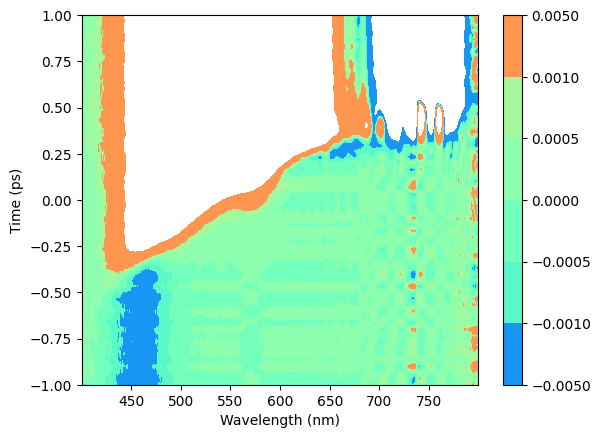

Fitting: 100%|██████████| 945/945 [00:09<00:00, 95.76it/s] 

Parameters([('a', <Parameter 'a', value=-238394.76934492055, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=1.0, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.8918431093267735, bounds=[-inf:inf]>)])


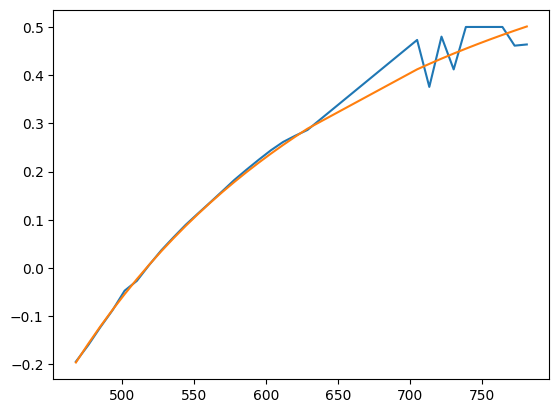

Parameters([('a', <Parameter 'a', value=-242760.92091756797, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=1.0, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.9075574468386393, bounds=[-inf:inf]>)])


array([[-1.09698819e-04, -1.09698819e-04, -1.09698819e-04, ...,
        -7.21614177e-05,  1.17593794e-04, -2.17770034e-04],
       [-2.76632492e-04, -2.76632492e-04, -2.76632492e-04, ...,
         1.00094721e-05,  7.79116996e-05, -1.48148235e-04],
       [-4.04849317e-04, -4.04849317e-04, -4.04849317e-04, ...,
        -7.36427200e-05,  1.93935186e-04,  1.50060712e-04],
       ...,
       [-1.24008747e-03, -1.74907076e-03,  9.70448061e-05, ...,
         5.01008710e-03,  4.56705802e-03,  5.12433600e-03],
       [-1.12750638e-03, -1.28358304e-03, -5.81391973e-04, ...,
         5.15934765e-03,  4.64658411e-03,  5.28077600e-03],
       [-4.24460264e-04, -4.44925177e-04, -4.53115810e-04, ...,
         4.86859371e-03,  4.75808207e-03,  5.03056000e-03]])

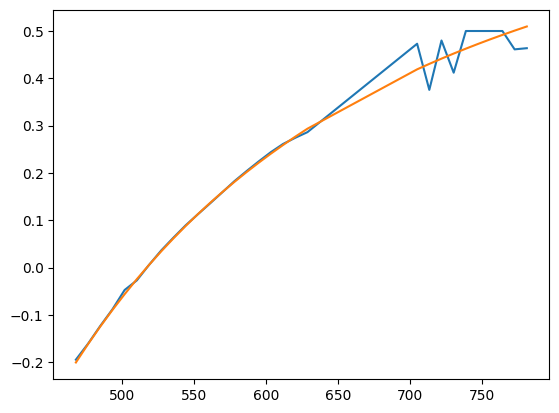

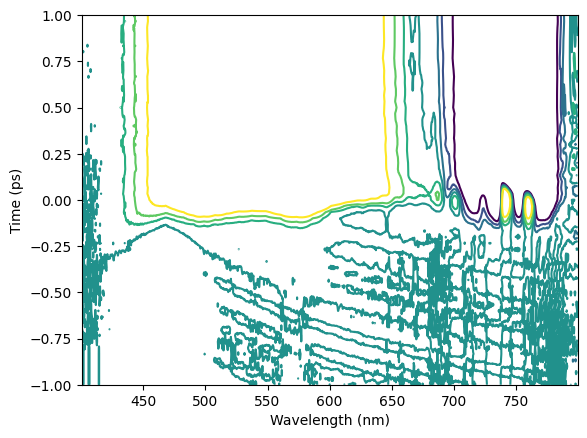

In [5]:
tamatrix = tamatrix_importer('NIR800',400,800) 
tamatrix.auto_bgcorr(25)
tamatrix.fit_correlation(3)
line = tamatrix.t0_list
plt.plot(line[0],line[1])
fit = polyfit(line[1],line[0],line[2])
plt.plot(line[0],fit)
tamatrix.auto_tcorr_fit()



Parameters([('a', <Parameter 'a', value=-242760.92091756797, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=1.0, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.9075574468386393, bounds=[-inf:inf]>)])


array([[-1.09698819e-04, -1.09698819e-04, -1.09698819e-04, ...,
        -7.11196068e-05,  1.16764489e-04, -2.16415414e-04],
       [-2.76632492e-04, -2.76632492e-04, -2.76632492e-04, ...,
         1.05259214e-05,  7.76145572e-05, -1.47235767e-04],
       [-4.04849317e-04, -4.04849317e-04, -4.04849317e-04, ...,
        -7.21609186e-05,  1.92765731e-04,  1.50240550e-04],
       ...,
       [-1.00033769e-03, -1.76358416e-03, -1.63173103e-05, ...,
         5.01010884e-03,  4.56703290e-03,  5.12433600e-03],
       [-9.94496846e-04, -1.29455507e-03, -6.31336251e-04, ...,
         5.15936886e-03,  4.64656003e-03,  5.28077600e-03],
       [-3.98410288e-04, -4.43364298e-04, -4.65672652e-04, ...,
         4.86859745e-03,  4.75807365e-03,  5.03056000e-03]])

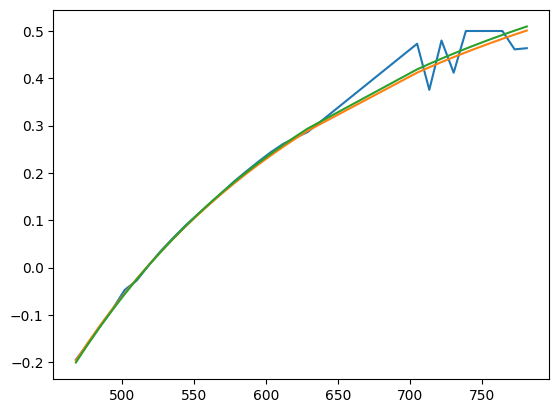

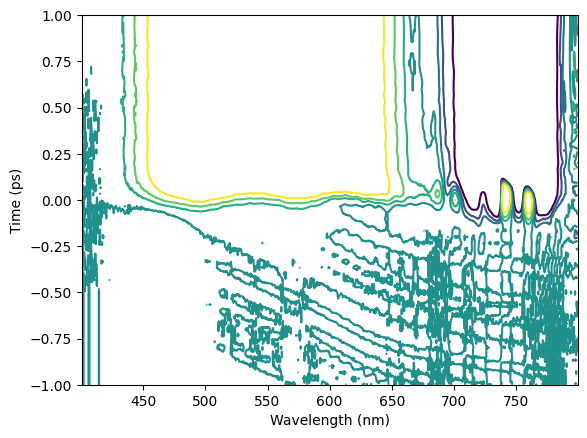

In [6]:
plt.plot(line[0],line[1])
plt.plot(line[0],line[2])
fit = polyfit(line[1],line[0],line[2])
plt.plot(line[0],fit)
tamatrix.auto_tcorr('NIR800_line')

C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:71: RuntimeWarning: divide by zero encountered in log
  np.log(self.tatime0), self.trace_array[:, i], label=f'{wavelength} nm trace {i+1}')
C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:71: RuntimeWarning: invalid value encountered in log
  np.log(self.tatime0), self.trace_array[:, i], label=f'{wavelength} nm trace {i+1}')
C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:74: RuntimeWarning: divide by zero encountered in log
  self.ax_k.plot(np.log(self.tatime0), self.trace_avg,
C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:74: RuntimeWarning: invalid value encountered in log
  self.ax_k.plot(np.log(self.tatime0), self.trace_avg,
C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:65: RuntimeWarning: divide by zero encountered in log
  self.ax_k.plot(np.log(self.tatime0), self.trace_avg,
C:\Users\kentc\AppData\Local\Temp\ipykernel_38152\73394431.py:65: RuntimeWarning: inv

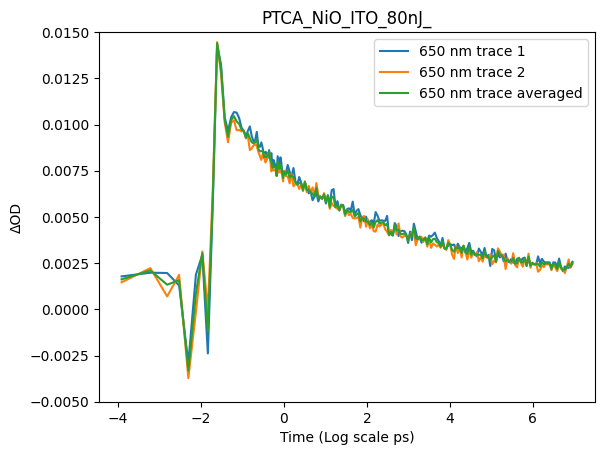

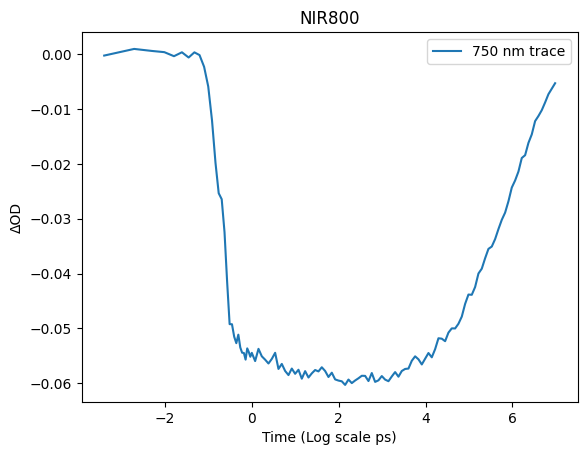

In [7]:
# load data into objects and plot
ptca_nio_ito_80nj = load_spectra('PTCA_NiO_ITO_80nJ_', 2)

k_ptca_650nm = ptca_nio_ito_80nj.get_traces(650)  # get traces at 650 nm


ptca_nio_ito_80nj.ax_k.set_ylim(-0.005, 0.015)

#ptca_nio_ito_80nj.get_1ps()
NIR800 = load_spectra('NIR800')

k_NIR800_800nm = NIR800.get_traces(750)

C:\Users\Kent\AppData\Local\Temp\ipykernel_36540\1369786811.py:4: RuntimeWarning: invalid value encountered in divide
  y = (-np.log10((3000+x)/3000))/(-np.log10((2500+x)/2500))


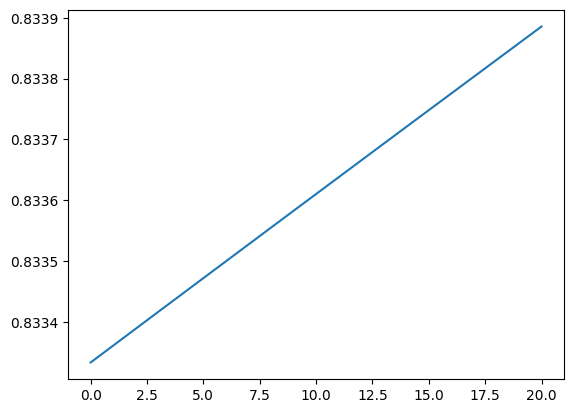